# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000L, 3073L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 3073L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 3073L)
Test labels shape:  (1000L,)
dev data shape:  (500L, 3073L)
dev labels shape:  (500L,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.334785
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.826685 analytic: -1.826685, relative error: 2.176313e-09
numerical: -3.059738 analytic: -3.059738, relative error: 1.536768e-08
numerical: -2.222691 analytic: -2.222691, relative error: 1.034822e-08
numerical: 0.509875 analytic: 0.509875, relative error: 1.397437e-07
numerical: 1.574950 analytic: 1.574950, relative error: 4.351741e-08
numerical: -2.396328 analytic: -2.396328, relative error: 2.709399e-08
numerical: -1.427628 analytic: -1.427628, relative error: 1.352781e-08
numerical: 0.332811 analytic: 0.332811, relative error: 2.264212e-07
numerical: -5.423174 analytic: -5.423174, relative error: 8.484112e-10
numerical: -1.111260 analytic: -1.111260, relative error: 3.962775e-08
numerical: -1.906622 analytic: -1.906622, relative error: 2.639102e-08
numerical: 0.883416 analytic: 0.883416, relative error: 3.602544e-09
numerical: -0.388592 analytic: -0.388592, relative error: 4.511739e-08
numerical: 2.894289 analytic: 2.894289, relative error: 8.457777e-09
numerical: 1.419

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.334785e+00 computed in 0.087000s
vectorized loss: 2.334785e+00 computed in 0.011000s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7,2e-7,5e-7]
regularization_strengths =[(1+0.1*i)*1e4 for i in range(-3,4)] + [(5+0.1*i)*1e4 for i in range(-3,4)]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate = lr, reg=rs, num_iters = 1500,
                     verbose = True)
        
        y_pred_train = softmax.predict(X_train)
        acc_train = np.mean(y_pred_train == y_train)
        
        y_pred_val = softmax.predict(X_val)
        acc_val = np.mean(y_pred_val == y_val)
        results[(lr, rs)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 112.257896
iteration 100 / 1500: loss 96.673200
iteration 200 / 1500: loss 83.920894
iteration 300 / 1500: loss 72.980502
iteration 400 / 1500: loss 63.490936
iteration 500 / 1500: loss 55.322404
iteration 600 / 1500: loss 48.312978
iteration 700 / 1500: loss 42.012285
iteration 800 / 1500: loss 36.784539
iteration 900 / 1500: loss 32.128566
iteration 1000 / 1500: loss 28.109191
iteration 1100 / 1500: loss 24.659814
iteration 1200 / 1500: loss 21.722966
iteration 1300 / 1500: loss 19.037704
iteration 1400 / 1500: loss 16.811495
iteration 0 / 1500: loss 127.811205
iteration 100 / 1500: loss 107.714450
iteration 200 / 1500: loss 91.182130
iteration 300 / 1500: loss 77.808344
iteration 400 / 1500: loss 66.565004
iteration 500 / 1500: loss 56.766509
iteration 600 / 1500: loss 48.707665
iteration 700 / 1500: loss 41.472382
iteration 800 / 1500: loss 35.692089
iteration 900 / 1500: loss 30.667777
iteration 1000 / 1500: loss 26.390114
iteration 1100 / 1500: loss 22.75

iteration 1200 / 1500: loss 5.576588
iteration 1300 / 1500: loss 4.623870
iteration 1400 / 1500: loss 3.956509
iteration 0 / 1500: loss 128.371105
iteration 100 / 1500: loss 91.802024
iteration 200 / 1500: loss 66.669210
iteration 300 / 1500: loss 48.682579
iteration 400 / 1500: loss 35.820942
iteration 500 / 1500: loss 26.495013
iteration 600 / 1500: loss 19.616951
iteration 700 / 1500: loss 14.759577
iteration 800 / 1500: loss 11.277372
iteration 900 / 1500: loss 8.664299
iteration 1000 / 1500: loss 6.755536
iteration 1100 / 1500: loss 5.470367
iteration 1200 / 1500: loss 4.473653
iteration 1300 / 1500: loss 3.768165
iteration 1400 / 1500: loss 3.238501
iteration 0 / 1500: loss 142.754596
iteration 100 / 1500: loss 99.095326
iteration 200 / 1500: loss 69.036413
iteration 300 / 1500: loss 48.579767
iteration 400 / 1500: loss 34.397832
iteration 500 / 1500: loss 24.448619
iteration 600 / 1500: loss 17.609251
iteration 700 / 1500: loss 12.922670
iteration 800 / 1500: loss 9.474406
itera

iteration 1100 / 1500: loss 1.991248
iteration 1200 / 1500: loss 1.872246
iteration 1300 / 1500: loss 1.878580
iteration 1400 / 1500: loss 1.870562
iteration 0 / 1500: loss 144.308550
iteration 100 / 1500: loss 58.488157
iteration 200 / 1500: loss 24.703453
iteration 300 / 1500: loss 11.067809
iteration 400 / 1500: loss 5.705208
iteration 500 / 1500: loss 3.429018
iteration 600 / 1500: loss 2.504440
iteration 700 / 1500: loss 2.129013
iteration 800 / 1500: loss 2.103648
iteration 900 / 1500: loss 2.054380
iteration 1000 / 1500: loss 1.920803
iteration 1100 / 1500: loss 1.914662
iteration 1200 / 1500: loss 1.927820
iteration 1300 / 1500: loss 1.943909
iteration 1400 / 1500: loss 1.978096
iteration 0 / 1500: loss 159.548580
iteration 100 / 1500: loss 58.460437
iteration 200 / 1500: loss 22.420902
iteration 300 / 1500: loss 9.421547
iteration 400 / 1500: loss 4.735428
iteration 500 / 1500: loss 2.921305
iteration 600 / 1500: loss 2.273348
iteration 700 / 1500: loss 2.074401
iteration 800 

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.382000


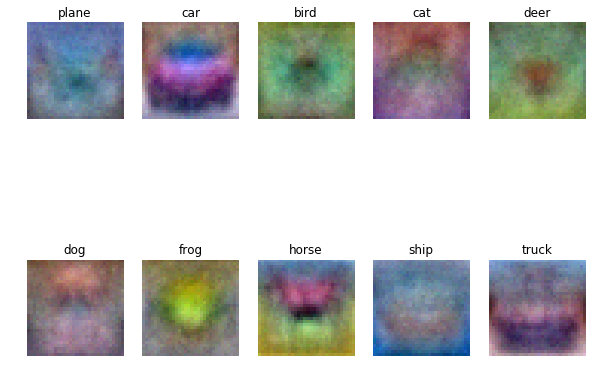

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])